In [1]:
run_number = 5812
default_cmap        = "jet"
XY_pitch            =  5.0

In [2]:
import os
import glob
import time
import collections
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt
import scipy.optimize    as opt
import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.database.load_db as dbf

from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import gausstext
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import labels
from invisible_cities.icaro. hst_functions import measurement_string

from   scipy.interpolate import splrep
from   scipy.interpolate import splev
from   scipy.interpolate import interp1d
from itertools import product
from functools import partial
from invisible_cities.evm.ic_containers import Measurement


Running on  Mon Jun 11 21:01:50 2018


In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 20
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [4]:
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst*_dev.h5")
print(inputfiles[-1])

/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5812_v0.9.6-29-g2ec1284_20180607_kr_dev.h5


In [4]:
kdst_all = dstf.load_dst(inputfiles[-1], "DST", "Events")

In [5]:
sel  = (kdst_all.nS1 == 1) & (kdst_all.nS2 == 1)
kdst = kdst_all[sel]

### Input maps

In [5]:
correction_filename = f"/Users/ansimez/Documents/InvCit/hdf5/Run4//XYMaps/corrections_run{run_number}.h5"

In [6]:
correction_filename

'/Users/ansimez/Documents/InvCit/hdf5/Run4//XYMaps/corrections_run5812.h5'

In [7]:
LT_correction0LT_corr   = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Lifetime")

GEO_correction0 = dstf.load_xy_corrections(correction_filename,
                                           group         =  "XYcorrections",
                                           node          = f"GeometryE_{XY_pitch:.1f}mm",
                                           norm_strategy =  "const",
                                           norm_opts     = {"value": 41.5})

In [8]:
LTmap = dstf.load_dst (correction_filename,
                       group = "XYcorrections",
                       node  = "Lifetime")

In [9]:
LTmap

,x,y,factor,uncertainty,nevt
0,-196.666672,-196.666672,6.318002e+07,3.687190e+11,0
1,-196.666672,-190.000000,6.318002e+07,3.687190e+11,0
2,-196.666672,-183.333328,6.318002e+07,3.687190e+11,0
3,-196.666672,-176.666672,6.318002e+07,3.687190e+11,0
4,-196.666672,-170.000000,6.318002e+07,3.687190e+11,0
5,-196.666672,-163.333328,6.318002e+07,3.687190e+11,0
6,-196.666672,-156.666672,6.318002e+07,3.687190e+11,0
7,-196.666672,-150.000000,6.318002e+07,3.687190e+11,0
8,-196.666672,-143.333328,6.318002e+07,3.687190e+11,0
9,-196.666672,-136.666672,6.318002e+07,3.687190e+11,0


In [10]:
bins = [400, 400]

detectorGeo = dbf.DetectorGeo()            
x_points = np.linspace(detectorGeo.XMIN[0], detectorGeo.XMAX[0], bins[0]+1)
y_points = np.linspace(detectorGeo.YMIN[0], detectorGeo.YMAX[0], bins[1]+1)
xs = list(product(x_points,y_points))
           
Xs = np.unique(LTmap.x.values)
Ys = np.unique(LTmap.y.values)
lt = corrf.Correction((Xs, Ys), LTmap.factor.values, LTmap.uncertainty.values, interp_method='linear')
new_lifetimes = lt(xs).value.reshape((x_points.size, y_points.size))

Xs = np.unique(LTmap.x.values)
Ys = np.unique(LTmap.y.values)
lt = corrf.Correction((Xs, Ys), LTmap.factor.values, LTmap.uncertainty.values, interp_method='cubic')
new_lifetimes_2 = lt(xs).value.reshape((x_points.size, y_points.size))

In [11]:
diff = new_lifetimes - new_lifetimes_2

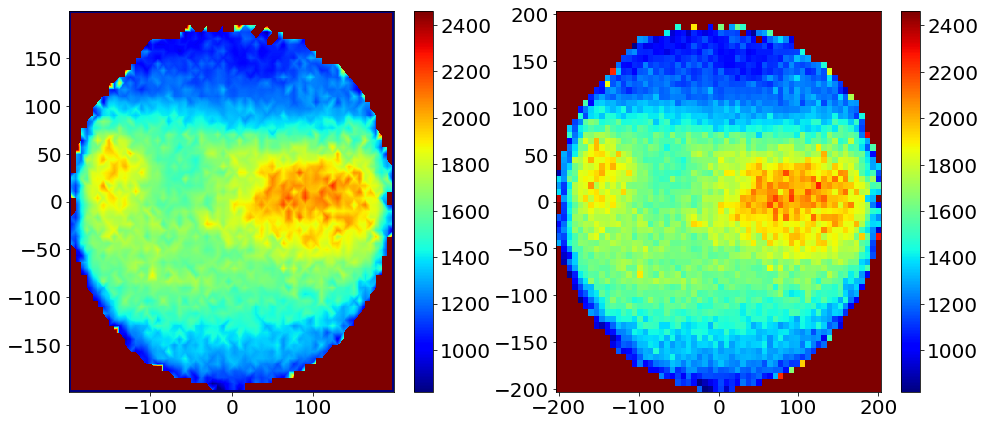

In [12]:
x = np.unique(x_points)
y = np.unique(y_points)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
*_, cb = display_matrix(x, y, new_lifetimes,
                        vmin = 0.5*np.median(new_lifetimes),
                        vmax = 1.5*np.median(new_lifetimes),
                        cmap = default_cmap,
                        new_figure=False)

Xs   = np.unique(LTmap.x.values)
Ys   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(Xs.size, Ys.size)

plt.subplot(1, 2, 2)
*_, cb = display_matrix(Xs, Ys, LT,
                        vmin = 0.5*np.median(LT),
                        vmax = 1.5*np.median(LT),
                        cmap = default_cmap,
                        new_figure=False)

In [20]:
x

-198.0

In [24]:
new_lifetimes

array([[        0.        ,         0.        ,         0.        , ...,
                0.        ,         0.        ,         0.        ],
       [        0.        ,         0.        ,         0.        , ...,
                0.        ,         0.        ,         0.        ],
       [        0.        ,         0.        ,  63180024.00000001, ...,
         63180024.        ,         0.        ,         0.        ],
       ..., 
       [        0.        ,         0.        ,  63180024.        , ...,
         63180024.        ,         0.        ,         0.        ],
       [        0.        ,         0.        ,         0.        , ...,
                0.        ,         0.        ,         0.        ],
       [        0.        ,         0.        ,         0.        , ...,
                0.        ,         0.        ,         0.        ]])

In [28]:
lt_test = new_lifetimes.flatten()

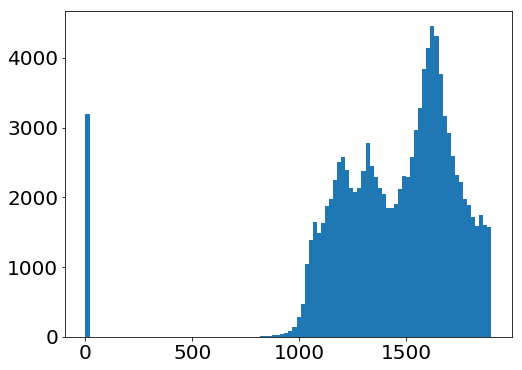

In [30]:
plt.hist(lt_test[lt_test<1900], 100);

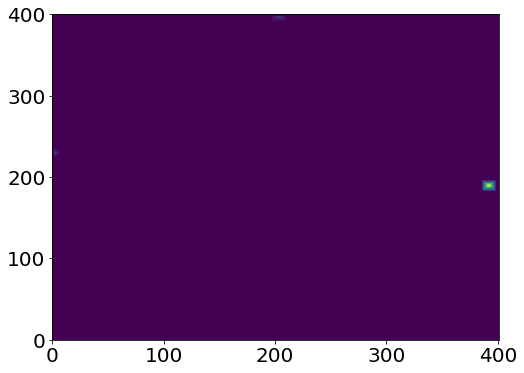

In [33]:
plt.pcolormesh(new_lifetimes)

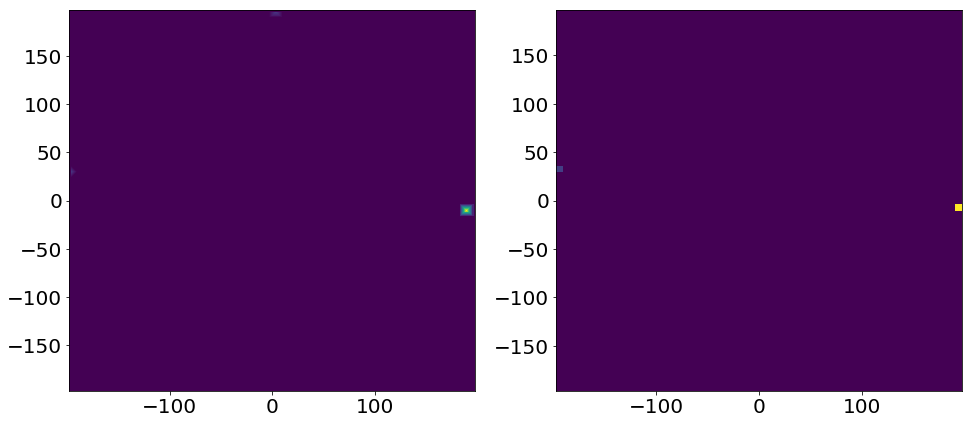

In [22]:
x = np.unique(x_points)
y = np.unique(y_points)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.pcolormesh(x, y, new_lifetimes)

Xs   = np.unique(LTmap.x.values)
Ys   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(Xs.size, Ys.size)

plt.subplot(1, 2, 2)
plt.pcolormesh(Xs, Ys, LT)

In [13]:
len(diff.flatten())

160801

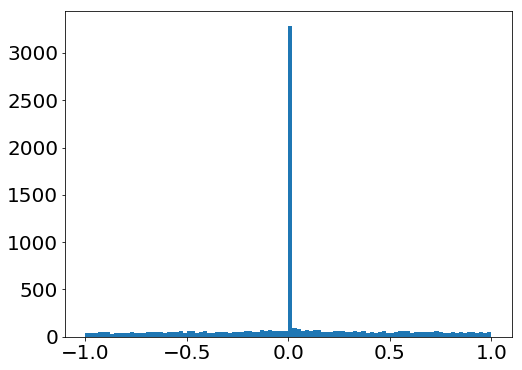

In [16]:
plt.hist(diff.flatten(), 100, [-1, 1]);

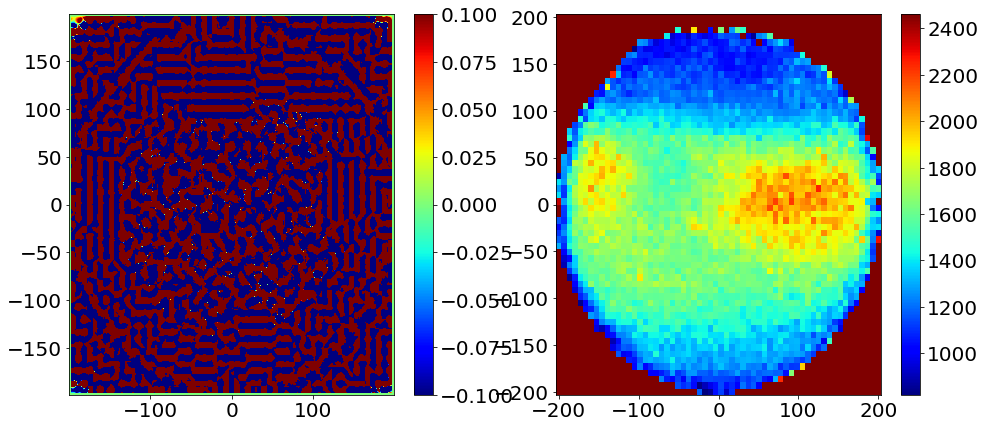

In [133]:
x = np.unique(x_points)
y = np.unique(y_points)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
*_, cb = display_matrix(x, y, diff,
                        vmin = 0.5*np.median(diff),
                        vmax = 1.5*np.median(diff),
                        cmap = default_cmap,
                        new_figure=False)

Xs   = np.unique(LTmap.x.values)
Ys   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(Xs.size, Ys.size)

plt.subplot(1, 2, 2)
*_, cb = display_matrix(Xs, Ys, LT,
                        vmin = 0.5*np.median(LT),
                        vmax = 1.5*np.median(LT),
                        cmap = default_cmap,
                        new_figure=False)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 3600

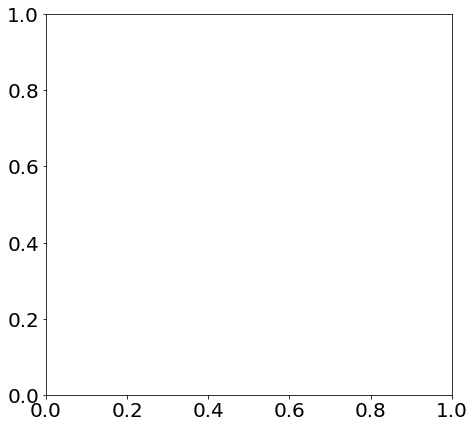

In [76]:
LTmap = dstf.load_dst (correction_filename,
                       group = "XYcorrections",
                       node  = "Lifetime")

Xs   = np.unique(LTmap.x.values)
Ys   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(Xs.size, Ys.size)
LTu = LTmap.uncertainty.values.reshape(Xs.size, Ys.size)

#sign = np.random.choice([-1, 1], size=LTs.shape)
#nsig = np.random.uniform(0, 1, LTs.shape)*10
LTall = np.array([LT + nsig * LTu for nsig in [0, 1, 3, 4, 7, 11, 18]]) # * sign, LTus)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
*_, cb = display_matrix(x, y, LT,
                        vmin = 0.5*np.median(LT),
                        vmax = 1.5*np.median(LT),
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime map")

plt.subplot(1, 2, 2)
*_, cb = display_matrix(x, y, LTnew[0],
                        vmin = 0.5*np.median(LT),
                        vmax = 1.5*np.median(LT), 
                        cmap = default_cmap,
                        new_figure=False)

cb.set_label("Lifetime unceratinty (µs)")
labels("X (mm)", "Y (mm)", "Lifetime uncertainty map")

plt.tight_layout()

In [16]:
LTnew[1].shape

(60, 60)

In [ ]:
lt  = corrf.Correction((Xs, Ys), LTnew[0], LTu)

In [ ]:
LTnew[]

In [36]:
LTnew.shape

(7, 160801)

In [64]:
LTnew = []

for LTmap in LTall[:]:    
    lt    = corrf.Correction((Xs, Ys), LTmap, LTu)
    i     = list(range(-200, 201))
    LTnew.append(lt(list(product(i,i))).value.reshape(len(i), len(i)))
    
LTnew  = np.array(LTnew)
spline = np.array([[interp1d([0, 1, 3, 4, 7, 11, 18], LTnew[:, i, j]) for i in range(LTnew.shape[1])] 
                                                                      for j in range(LTnew.shape[2])])

In [60]:
LTnew[:, 0, 0]

array([  6.31800240e+07,   3.68782148e+11,   1.10622015e+12,
         1.47493906e+12,   2.58109604e+12,   4.05597192e+12,
         6.63700478e+12])

In [68]:
spline[100,100](0.5)

array(1470.51416015625)

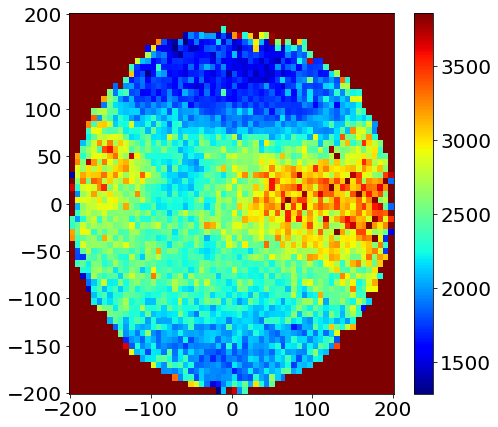

In [57]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
*_, cb = display_matrix(i, i, LTnew[-1],
                        vmin = 0.5*np.median(LTnew[-1]),
                        vmax = 1.5*np.median(LTnew[-1]),
                        cmap = default_cmap,
                        new_figure=False)

In [69]:
xs = (3, 2, 1)

In [70]:
x, y, t = xs

In [71]:
x

3

In [ ]:
LT

In [73]:
class SplineCorrections:
    """
    Interface for accessing any kind of corrections.
    Parameters
    ----------
    xs : np.ndarray
        Array of coordinates (x, y, t) corresponding to each correction.
    fs : np.ndarray
        Array of corrections or the values used for computing them.
    us : np.ndarray
        Array of uncertainties or the values used for computing them.
    norm_strategy : False or string
        Flag to set the normalization option. Accepted values:
        - False:    Do not normalize.
        - "max":    Normalize to maximum energy encountered.
        - "index":  Normalize to the energy placed to index (i,j).
    default_f, default_u : floats
        Default correction and uncertainty for missing values (where fs = 0).
    """ 

    def __init__(self, LTs, bins = [400, 400], interp_method = "linear"):
        if isinstance(bins, int):
            bins = [bins, bins]

        detectorGeo = dbf.DetectorGeo()            
        x_points = np.linspace(detectorGeo.XMIN[0], detectorGeo.XMAX[0], bins[0]+1)
        y_points = np.linspace(detectorGeo.YMIN[0], detectorGeo.YMAX[0], bins[1]+1)
        self._xs = list(product(x_points,y_points))
        self._ts = np.array([LT.time[0] for LT in LTs])
        
        LTnew = []
        for LT in LTs:    
            Xs = np.unique(LT.x.values)
            Ys = np.unique(LT.y.values)
            lt = corrf.Correction((Xs, Ys), LT.lifetime.values, LT.uncertainty.values, interp_method=interp_method)
            LTnew.append(lt(*self._xs).value.reshape(*self._xs.shape))    
        LTnew  = np.array(LTnew)

        self._interpolator = self._init_interpolator(interp_method, LTnew)               

    def __call__(self, *coords):
        """
        Compute the correction factor.
        Parameters
        ----------
        *coords: Sequence of nd.arrays
                 Each array is one coordinate. The number of coordinates must match
                 that of the `xs` array in the init method.
        """
        xs, ys, ts = coords
        
        closer_x = lambda x: np.abs(self_.xs[0,:] - x).argmin()
        closer_y = lambda x: np.abs(self_.xs[:,0] - x).argmin()
        
        i = np.apply_along_axis(closer_x, 0, xs)
        j = np.apply_along_axis(closer_y, 0, ys)
        
        value  = self._interpolator[i,j](ts).flatten()
        return value

    def _init_interpolator(self, method, LTnew):
        self.interpolator = np.array([[interp1d(*self._ts, LTnew[:, i, j], kind=method) 
                                       for i in range(LTnew.shape[1])] 
                                       for j in range(LTnew.shape[2])])

In [ ]:
ts = np.array([0, 1, 3, 4, 7, 11, 18])
LTnew = np.array([LT + nsig * LTu for nsig in [0, 1, 3, 4, 7, 11, 18]]) # * sign, LTus) 

spline_corr = SplineCorrections((ts,x,y), LTnew, interp_method='linear')

3
25200
25200
25200
(25200,)


In [ ]:
spline_corr([-63.3], [-63.3], [0.5])

In [146]:
spline_corr(-63.3, -63.3, 0.)

Measurement(value=1727.0315988497046, uncertainty=0.0)

In [ ]:
spline_corr(-63.3, -63.3, 0.)

In [ ]:
dbf.DetectorGeo.XMIN